In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time
import math

In [23]:
#A block of every other spiking layer (updates them all at once)
class Spike1d_block(torch.nn.Module):
    def __init__(self, layers):
        super(Spike1d_block, self).__init__()
        self.layers = layers
        
    def forward(self,in_spikes):
        out_spikes = []
        out_pots = []
        for idx,l in enumerate(self.layers):
            o, p = l(in_spikes[idx:idx + l.get_n_inputs()])
            out_pots.append(p)
            out_spikes.append(o)
        
        return out_spikes, out_pots
    
    def get_empty_spikes(self):
        out = []
        for i in self.layers:
            out.append(i.get_empty_spikes())
        return out

class Dense(torch.nn.Module):
    def __init__(self, n_in, n_out , sigmoid = False, pointwise = False):
        super(Dense, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.sigmoid = sigmoid
        self.pointwise = pointwise
        
        if not pointwise:
            self.weight = torch.zeros([n_in, n_out])
            self.reset_parameters()
        else:
            if n_in != n_out:
                raise Exception('n_in must be equal to n_out for pointwise operation, {} and {} where given'.format(n_in,n_out))
            self.weight = torch.zeros([n_in])
            self.reset_parameters()
            
    def sig(self,x):
        return 1 / (1 + torch.exp(-x))
    
    def sig_d(self, x):
        return x * (1 - x)

    def forward(self, a):
        if not self.pointwise:
            a = torch.matmul(a,self.weight).squeeze()
        else:
            a = self.weight * a
            
        if self.sigmoid:
            a = self.sig(a)
            
        return a

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(0))
        self.weight.data.uniform_(0, stdv)
        
    def weight_update(self, errors, lr = 0.01):
        pass
        


In [7]:
class Spike1d(torch.nn.Module):
    def __init__(self, n_in,n_out, thresh = 1, input_connections = [], mod = False, verbose = False):
        super(Spike1d, self).__init__()
        self.potentials = Parameter(torch.zeros(n_out, dtype=torch.float),requires_grad=False)
        self.thresh = thresh
        self.mod = mod
        self.n_out = n_out
        self.n_in = n_in
        self.verbose = verbose
        
        #Create list of timing errors and weights for each connected layer
        if isinstance(n_in, int):
            fc = [Dense(n_in,n_out)]
            timings = [torch.zeros([n_out,n_in])]
        else:
            fc = []
            timings = []
            for idx,i in enumerate(n_in):
                if idx in input_connections:
                    fc.append(0)
                    timings.append(0)
                else:
                    fc.append(Dense(i,n_out))
                    timings.append(torch.zeros([n_out, i]))
                    
        self.timings = timings
        self.fc = fc
                
    def get_empty_spikes(self):
        return torch.zeros([self.n_out])
    
    def get_n_inputs(self):
        return len(self.n_in)
    
    def forward(self, in_spikes):
        #update potentials
        delta_p = torch.zeros([self.n_out])
        for idx,f in enumerate(self.fc):
            try:
                #only positive weights for now
                delta_p += (f(in_spikes[idx]))
            except:
                #Input connections are not weighted (should be pointwise weighted)
                delta_p += in_spikes[idx]
        self.potentials = Parameter(self.potentials + delta_p)
        
        #generate spikes and uptade potentials accordingly
        spikes = (self.potentials >= self.thresh).float()
        if self.mod:
            #After spike overflow is kept
            self.potentials = Parameter(self.potentials - (spikes * self.thresh))
        else:
            #After spike potential is set to zero removing any overlow
            self.potentials = Parameter(self.potentials * (1 - spikes))

        #Calculate errors
        errors = []
        idx = 0
        for t in self.timings:
            #no errors on input layer
            if isinstance(t, int):
                errors.append(torch.tensor([0] * self.n_in[idx],dtype = torch.float))
                idx += 1
                continue
                
            #Step timing errors
            t += 1 * torch.sign(t)
            
            #on in fire (Neurons want to fire sooner : weights are increased)        
            t = t.transpose(0,1)
            positive_errors = []
            for i in range(in_spikes[idx].shape[0]):
                if in_spikes[idx][i] == 1:
                    if(self.verbose):
                        print("in fire")
                        pass
                    positive_errors.append(t[i] * (t[i] < 0))
                    t[i][t[i] >= 0] += 1
                    t[i][t[i] < 0] = 0
                else:
                    positive_errors.append(torch.zeros(spikes.shape,dtype = torch.float))
                    
            errors.append(torch.stack(positive_errors,-1).squeeze().transpose(0,1))
            
            t = t.transpose(0,1)
        
            #on out fire (Neurons want to fire later : weights are decreased)
            negative_errors = []
            for i in range(spikes.shape[0]):
                if(spikes[i] == 1):
                    if(self.verbose):
                        print("out fire")
                        pass
                    negative_errors.append(t[i] * (t[i] > 0))
                    t[i][t[i] <= 0] -= 1
                    t[i][t[i] > 0] = 0
                else:
                    negative_errors.append(torch.zeros(in_spikes[idx].shape,dtype = torch.float))
                                
            errors[idx] += torch.stack(negative_errors,-1).squeeze()
          
            idx += 1
        
        if self.verbose:
            print(self.timings)
            print(errors)
            print()
        
        return spikes, (self.potentials + spikes)


class Net(torch.nn.Module):
    def __init__(self, mod = False):
        super(Net, self).__init__()
        n_in = 2
        self.spike1 = Spike1d([n_in,4],n_in, input_connections = [0], verbose = False)
        
        self.spike2 = Spike1d([n_in], 4, verbose = False)
        
        #self.spike3 = Spike1d([4],4)
        
        self.odd_layers = Spike1d_block([self.spike1])#,self.spike3])
        self.odd_layer_spikes = self.odd_layers.get_empty_spikes()
        self.even_layers =  Spike1d_block([self.spike2])
        self.even_layer_spikes = self.even_layers.get_empty_spikes()
       
    def forward(self, x):
        draw = []
        
        #Update every odd layer
        self.odd_layer_spikes, pots = self.odd_layers([x] + self.even_layer_spikes)
        draw.append(pots)
     
        #Update every even layer
        self.even_layer_spikes, pots = self.even_layers(self.odd_layer_spikes)
        draw.append(pots)
                
        return x, draw


<IPython.core.display.Javascript object>


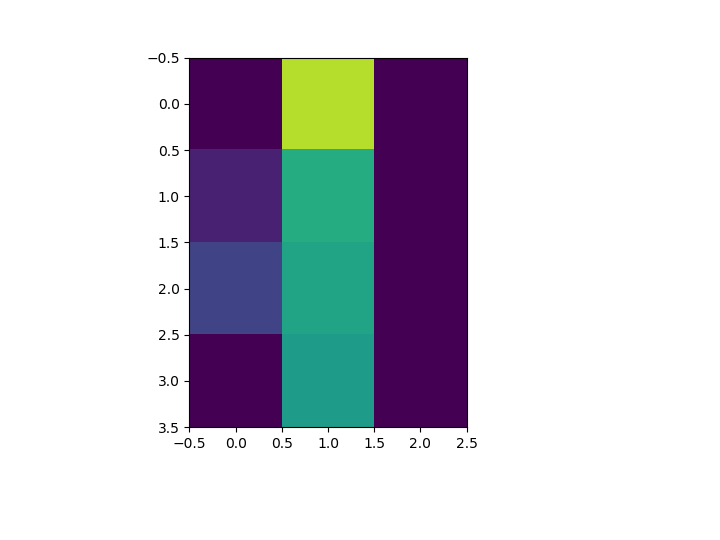

KeyboardInterrupt: 

In [4]:
model = Net(mod = False)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

def draw_spikes(spikes, ax, l_dim = 4, n_layers = 3):
    #this function recombines and draws the lists of odd and even spikes
    to_draw = torch.zeros(n_layers,l_dim) - 0.1
    e = even = odd = 0
    while True:
        e += 1
        if e % 2 != 0:
            spike_block = spikes[0]
            i = odd
            odd += 1
        else:
            spike_block = spikes[1]
            i = even
            even += 1
        
        if(i > len(spike_block)-1):
            break
        offset = (l_dim - spike_block[i].shape[0]) // 2
        try:
            to_draw[e-1][offset:spike_block[i].shape[0] + offset] = spike_block[i].clone().detach()
        except:
            to_draw[e-1][offset:spike_block[i].shape[0] + offset] = torch.tensor(spike_block[i])

    to_draw = to_draw.t()
    
    ax.clear()
    ax.imshow(to_draw,vmin=-0.1, vmax=1)    

x_fire = np.array(random.sample(range(1,150), 15))
y_fire =[]# x_fire + 2

for e in range(150):
    in_stream = torch.tensor([e in x_fire, e in y_fire], dtype=torch.float)#,e in y_fire], dtype=torch.float)
    #if 1 in in_stream:
    #   print("In signal")
    out,spikes = model(in_stream)
    draw_spikes(spikes, ax, l_dim = 4, n_layers = 3)
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    fig.canvas.draw()
    time.sleep(0.1)